In [1]:

import pytz
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from matplotlib.ticker import FormatStrFormatter

from pyts.image import GramianAngularField

gasf = GramianAngularField(method='summation')

In [ ]:
pacific = pytz.timezone('US/Pacific')
DATA_PATH = '../dataset'
FILEDS = ['JobID', 'JobIDRaw' , 'JobName', 'Partition', 'Submit', 'Start', 
          'End', 'State', 'NTasks', 'NodeList', 'AllocNodes', 'AllocCPUS', 
          'SystemCPU', 'TotalCPU', 'Elapsed']

In [3]:
def ldms_jobidraw_to_pandas(jobidraw, sampler, metrics=None, prefix=DATA_PATH):
    j=str(jobidraw)
    fp = prefix / Path(j)
    files = list(fp.glob(f"*_{sampler}*"))
    if len(files) == 0:
        # raise LookupError(f"No files found for jobidraw={jobidraw} sampler={sampler} metrics={metrics} in {prefix}")
        return pd.DataFrame()
    if metrics:
        dfs = [pd.read_parquet(fn, columns=metrics) for fn in files]
    else:
        dfs = [pd.read_parquet(fn) for fn in files]
    return pd.concat(dfs)

In [4]:
def cal_group_freq(min_t, max_t, steps):
    min_step = min_t.timestamp()
    max_step = max_t.timestamp()
    delta_step = max_step - min_step
    freq_int = int(delta_step/steps * 1000)
    return f'{freq_int}ms'

In [14]:
def read_job_df(jobid: int, sampler: str, total_step = 128):
    """ Read parquet files of job metrics, process the data and return a list
    of numpy arrays grouped by producers

    Args:
        jobid (int): Job Id
        sampler (str): The sampler of LDMS
        total_step (int, optional): number of rows in each dataframe. Defaults to 32.

    Returns:
        list: A list of numpy arrays grouped by producers
    """
    df = pd.DataFrame()
    np_array = []
    metrics = ['Time', 'ProducerName', 'jobidraw']
    
    if sampler == 'syspapi*':
        metrics.extend(['PAPI_TOT_CYC', 'PAPI_TOT_INS'])
        try:
            df = ldms_jobidraw_to_pandas(jobid, 'syspapi_KnL272', metrics)
        # except LookupError:
            # if df.empty:
            #     df = ldms_jobidraw_to_pandas(jobid, 'syspapi_Hsw64', metrics)
        except:
            pass
    else:
        if sampler == 'cray_aries_sampler':
            metrics.extend(['power(W)'])
        if sampler == 'meminfo':
            metrics.extend(['MemFree', 'MemTotal'])
        try:
            df = ldms_jobidraw_to_pandas(jobid, sampler, metrics)
        except:
            pass
    
    if df.empty:
        return
    
    # Remove unused categories
    if df['ProducerName'].dtypes.name == 'category':
        df['ProducerName'] = df['ProducerName'].cat.remove_unused_categories()
        
    # Change date format and set Time as index
    df = df.drop_duplicates()
    df['Time'] = df['Time'].dt.tz_localize(None)
    df['Time'] = df['Time'].astype('datetime64[s]')
    df.set_index('Time', inplace=True)
    
    # Derive metrics
    if sampler == 'cray_aries_sampler':
        metric = 'power'
        df[metric] = df['power(W)']
        df.drop(columns = ['power(W)'], inplace = True)
    if sampler == 'syspapi*':
        metric = 'papi_ipc'
        df[metric] = df.apply(lambda row: row.PAPI_TOT_INS/row.PAPI_TOT_CYC, axis=1)
        df.drop(columns = ['PAPI_TOT_INS', 'PAPI_TOT_CYC'], inplace = True)
    if sampler == 'meminfo':
        metric = 'mem_usage'
        df[metric] = df.apply(lambda row: (row.MemTotal - row.MemFree)/row.MemTotal, axis=1)
        df.drop(columns = ['MemTotal', 'MemFree'], inplace = True)
    
    min_t = df.index.min()
    max_t = df.index.max()
    freq = cal_group_freq(min_t, max_t, total_step)
    
    df_gps = df.groupby(['ProducerName'], as_index=False)
    
    producer_names = list(df_gps.groups.keys())

    for producer in producer_names:
        df_t = df_gps.get_group(producer)
        df_t = df_t.groupby(pd.Grouper(freq=freq)).mean().pad()
        df_t = df_t.iloc[:total_step]
        df_t.reset_index(inplace=True)
        np_a = df_t[metric].to_numpy()
        np_array.append((f'{producer}', np_a))
        
    return np_array

In [6]:
def read_job_df_raw(jobid: int, sampler: str):
    """ Read parquet files of job metrics, process the data and return a list
    of numpy arrays grouped by producers

    Args:
        jobid (int): Job Id
        sampler (str): The sampler of LDMS
        total_step (int, optional): number of rows in each dataframe. Defaults to 32.

    Returns:
        list: A list of numpy arrays grouped by producers
    """
    df = pd.DataFrame()
    np_array = []
    metrics = ['Time', 'ProducerName']
    
    if sampler == 'syspapi*':
        metrics.extend(['PAPI_TOT_CYC', 'PAPI_TOT_INS'])
        try:
            df = ldms_jobidraw_to_pandas(jobid, 'syspapi_KnL272', metrics)
        # except LookupError:
            if df.empty:
                df = ldms_jobidraw_to_pandas(jobid, 'syspapi_Hsw64', metrics)
        except:
            pass
    else:
        if sampler == 'cray_aries_sampler':
            metrics.extend(['power(W)'])
        if sampler == 'meminfo':
            metrics.extend(['MemFree', 'MemTotal'])
        try:
            df = ldms_jobidraw_to_pandas(jobid, sampler, metrics)
        except:
            pass
    
    if df.empty:
        return
    
    # Remove unused categories
    if df['ProducerName'].dtypes.name == 'category':
        df['ProducerName'] = df['ProducerName'].cat.remove_unused_categories()
        
    # Change date format and set Time as index
    df = df.drop_duplicates()
    df['Time'] = df['Time'].dt.tz_localize(None)
    df['Time'] = df['Time'].astype('datetime64[s]')
    df.set_index('Time', inplace=True)
    
    # Derive metrics
    if sampler == 'cray_aries_sampler':
        metric = 'power'
        df[metric] = df['power(W)']
        df.drop(columns = ['power(W)'], inplace = True)
    if sampler == 'syspapi*':
        metric = 'papi_ipc'
        df[metric] = df.apply(lambda row: row.PAPI_TOT_INS/row.PAPI_TOT_CYC, axis=1)
        df.drop(columns = ['PAPI_TOT_INS', 'PAPI_TOT_CYC'], inplace = True)
    if sampler == 'meminfo':
        metric = 'mem_usage'
        df[metric] = df.apply(lambda row: (row.MemTotal - row.MemFree)/row.MemTotal, axis=1)
        df.drop(columns = ['MemTotal', 'MemFree'], inplace = True)
    
    df_gps = df.groupby(['ProducerName'], as_index=False)
    
    producer_names = list(df_gps.groups.keys())

    for producer in producer_names:
        df_t = df_gps.get_group(producer)
        df_t.reset_index(inplace=True)
        np_a = df_t[metric].to_numpy()
        np_array.append((f'{producer}', np_a))
        
    return np_array

In [21]:
def build_signature(jobid: int, debug=False):
    if debug:
        print(f'Job id: {jobid}')
    signature = {}
    samplers = {
        'cray_aries_sampler': 'power',
        'syspapi*': 'papi_ipc',
        'meminfo': 'mem_usage'
    }
    sig_list = []
    producer = {}
    for sampler in samplers.keys():
        if debug:
            print(f'sampler: {sampler}')
        s_data = read_job_df(jobid, sampler)
        
        if not s_data:
            return
        
        if producer:
            for i in s_data:
                if debug:
                    print(f'i value: {i}')
                X = np.array([i[1]])
                # print(X)
                X_gasf = gasf.fit_transform(X)
                # print(X_gasf.shape)
                producer[i[0]].append(X_gasf)
        else:
            for i in s_data:
                if debug:
                    print(f'i value: {i}')
                X = np.array([i[1]])
                X_gasf = gasf.fit_transform(X)
                producer.update({
                    i[0]: [X_gasf]
                })
    if debug:
        print(f'Producer: {producer}')
    for key, value in producer.items():
        tuple_value = tuple([i[0] for i in value])
        stacked = np.dstack(tuple_value)
        # print(stacked.shape)
        signature.update({
            key: stacked
        })
    return signature

In [ ]:
jobid = 50812172
sample_sig = build_signature(jobid)
# print(sample_sig)

In [9]:
sample_mem_raw = read_job_df_raw(jobid, 'meminfo')
sample_mem_raw

[('nid05799',
  array([0.03279347, 0.03294205, 0.03308925, 0.03401097, 0.0342158 ,
         0.03427514, 0.0336367 , 0.03403986, 0.03555517, 0.03719052,
         0.0372569 , 0.03725698, 0.05330056, 0.05579267, 0.06628956,
         0.10751101, 0.17203595, 0.1756655 , 0.17903581, 0.18259295,
         0.18588482, 0.18939024, 0.19399792, 0.19758311, 0.20084948,
         0.2043479 , 0.20768676, 0.21124892, 0.19316399, 0.22029207,
         0.24583915, 0.27270706, 0.29824904, 0.32544843, 0.34825695,
         0.36615699, 0.38384794, 0.38390404, 0.38390926, 0.38390926,
         0.38390671, 0.38390416, 0.38391408, 0.38391278, 0.38391023,
         0.38390639, 0.38390861, 0.38390861, 0.38390352, 0.38390352,
         0.38390606, 0.38390606, 0.38390352, 0.38390352, 0.38390299,
         0.38390048, 0.38390048, 0.38390048, 0.38389712, 0.38389712,
         0.38389967, 0.38389967, 0.38389744, 0.38389234, 0.38388854,
         0.38388854, 0.38388563, 0.38388563, 0.38389073, 0.38389328,
         0.38389583,

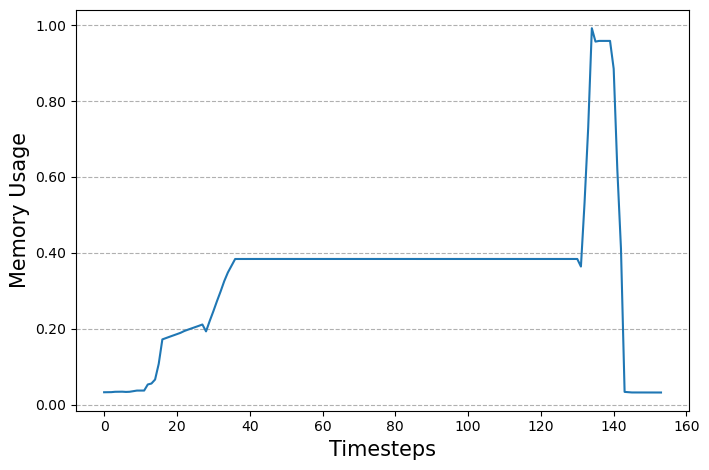

In [10]:
x_ticks = np.arange(len(sample_mem_raw[0][1]))

w,h = figaspect(2/3)
fig, ax = plt.subplots(figsize=(w,h))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.grid(linestyle='--')
plt.xlabel('Timesteps', fontsize = 15)
plt.ylabel('Memory Usage', fontsize = 15)
plt.plot(x_ticks, sample_mem_raw[0][1])

plt.tight_layout()
# plt.savefig(f'./png/{jobid}_mem.png', format='png', dpi=1000)
plt.show()

In [11]:
# Sample metrics
ts = 128
sample_power = read_job_df(jobid, 'cray_aries_sampler', total_step = ts)
sample_ipc = read_job_df(jobid, 'syspapi*', total_step = ts)
sample_mem = read_job_df(jobid, 'meminfo', total_step = ts) 

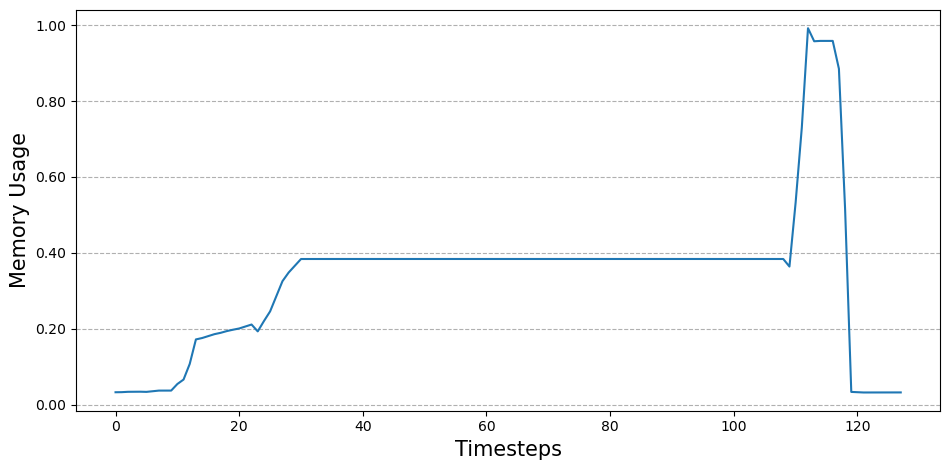

In [12]:
x_ticks = np.arange(ts)

w,h = figaspect(1/2)
fig, ax = plt.subplots(figsize=(w,h))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.grid(linestyle='--')
plt.xlabel('Timesteps', fontsize = 15)
plt.ylabel('Memory Usage', fontsize = 15)
plt.plot(x_ticks, sample_mem[0][1])

plt.tight_layout()
# plt.savefig(f'./png/{jobid}_mem.png', format='png', dpi=1000)
plt.show()

In [13]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
sample_mem_scaled = NormalizeData(sample_mem[0][1])
sample_mem_scaled

array([7.21730588e-04, 9.52536761e-04, 1.91300254e-03, 2.12645344e-03,
       2.18828292e-03, 1.73306019e-03, 3.52212962e-03, 5.22623623e-03,
       5.29540428e-03, 5.29548863e-03, 2.33120140e-02, 3.55486635e-02,
       7.85031580e-02, 1.45740866e-01, 1.49523008e-01, 1.54888361e-01,
       1.60171977e-01, 1.63824767e-01, 1.68626168e-01, 1.72362086e-01,
       1.75765786e-01, 1.81150898e-01, 1.86602437e-01, 1.67757181e-01,
       1.96025781e-01, 2.22646917e-01, 2.63952323e-01, 3.05603147e-01,
       3.29370595e-01, 3.48023192e-01, 3.66457910e-01, 3.66519086e-01,
       3.66521806e-01, 3.66519149e-01, 3.66516492e-01, 3.66526825e-01,
       3.66524147e-01, 3.66518812e-01, 3.66521131e-01, 3.66521131e-01,
       3.66515817e-01, 3.66517146e-01, 3.66518474e-01, 3.66515817e-01,
       3.66515817e-01, 3.66515269e-01, 3.66512654e-01, 3.66512654e-01,
       3.66509153e-01, 3.66509153e-01, 3.66511810e-01, 3.66510651e-01,
       3.66504177e-01, 3.66500212e-01, 3.66500212e-01, 3.66497175e-01,
      

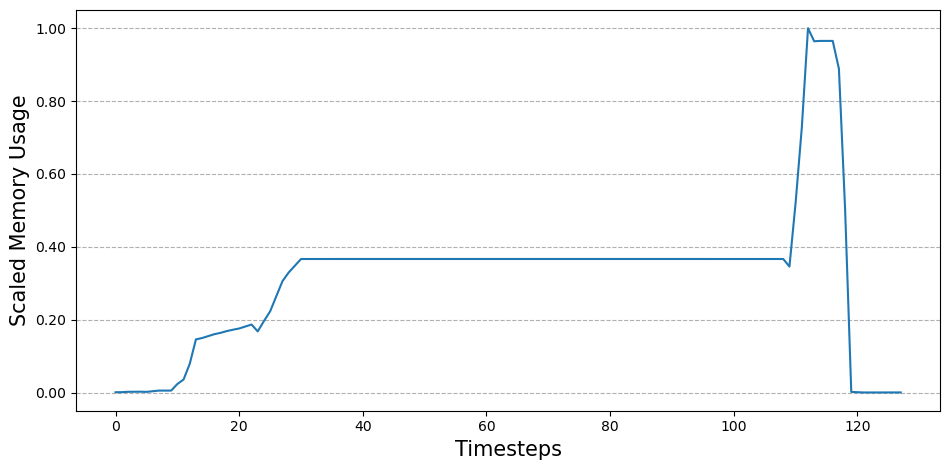

In [14]:
x_ticks = np.arange(ts)

w,h = figaspect(1/2)
fig, ax = plt.subplots(figsize=(w,h))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.grid(linestyle='--')
plt.xlabel('Timesteps', fontsize = 15)
plt.ylabel('Scaled Memory Usage', fontsize = 15)
plt.plot(x_ticks, sample_mem_scaled)

plt.tight_layout()
# plt.savefig(f'./png/{jobid}_mem.png', format='png', dpi=1000)
plt.show()

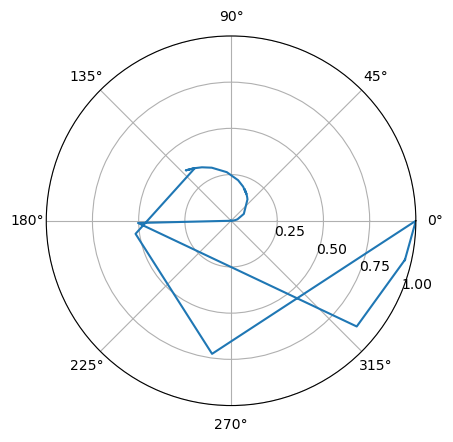

In [15]:
r = sample_mem_scaled
theta = 2 * np.pi * r

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, r)
ax.set_rmax(1)
ax.set_rticks([0.25, 0.5, 0.75, 1])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

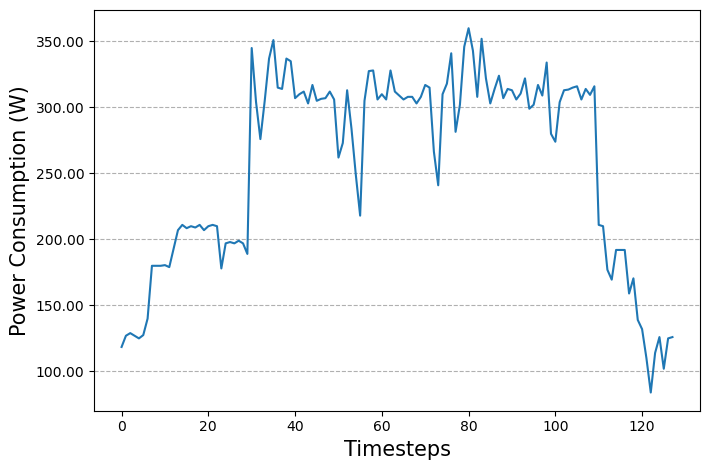

In [16]:
x_ticks = np.arange(ts)

w,h = figaspect(2/3)
fig, ax = plt.subplots(figsize=(w,h))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.grid(linestyle='--')
plt.xlabel('Timesteps', fontsize = 15)
plt.ylabel('Power Consumption (W)', fontsize = 15)
plt.plot(x_ticks, sample_power[0][1])

plt.tight_layout()
# plt.savefig(f'./png/{jobid}_power.png', format='png', dpi=1000)
plt.show()

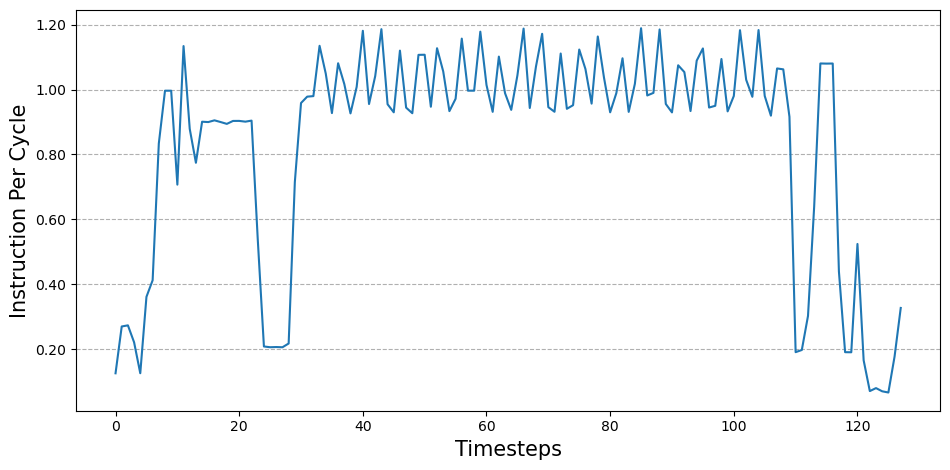

In [17]:
w,h = figaspect(1/2)
fig, ax = plt.subplots(figsize=(w,h))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.grid(linestyle='--')
plt.xlabel('Timesteps', fontsize = 15)
plt.ylabel('Instruction Per Cycle', fontsize = 15)
plt.plot(x_ticks, sample_ipc[0][1])

plt.tight_layout()
# plt.savefig(f'./png/{jobid}_ipc.png', format='png', dpi=1000)
plt.show()

In [18]:
def plot_gramian(sample_df, sample_name):
    
    x = sample_df[0][1]
    X = np.array([x])
    time_points = np.arange(32)

    color = 'Greys' # 'Greys', 'rainbow'
    # color = 'rainbow'

    # Compute Gramian angular fields
    gasf = GramianAngularField(method='summation')
    X_gasf = gasf.fit_transform(X)

    gadf = GramianAngularField(method='difference')
    X_gadf = gadf.fit_transform(X)

    # Plot the time series and its recurrence plot
    width_ratios = (2, 7, 7, 0.4)
    height_ratios = (2, 7)
    width = 10
    height = width * sum(height_ratios) / sum(width_ratios)
    fig = plt.figure(figsize=(width, height))
    gs = fig.add_gridspec(2, 4,  width_ratios=width_ratios,
                        height_ratios=height_ratios,
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.1, hspace=0.1)

    value_ticks = [min(x), max(x)]
    reversed_value_ticks = value_ticks[::-1]

    # Define the ticks and their labels for both axes
    time_ticks = time_points
    time_ticklabels = time_points

    # Plot the time series on the left with inverted axes
    ax_left = fig.add_subplot(gs[1, 0])
    ax_left.plot(x, time_points)
    # ax_left.set_xticks(reversed_value_ticks)
    # ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
    # ax_left.set_yticks(time_ticks)
    # ax_left.set_yticklabels(time_ticklabels, rotation=90)
    ax_left.invert_xaxis()
    ax_left.get_xaxis().set_major_formatter(FormatStrFormatter('%.2f'))
    ax_left.xaxis.set_tick_params(rotation=90)
    ax_left.xaxis.grid(linestyle='--')

    # Plot the time series on the top
    ax_top1 = fig.add_subplot(gs[0, 1])
    ax_top2 = fig.add_subplot(gs[0, 2])
    for ax in (ax_top1, ax_top2):
        ax.plot(time_points, x)
        # ax.set_xticks(time_ticks)
        # ax.set_xticklabels(time_ticklabels)
        # ax.set_yticks(value_ticks)
        ax.xaxis.tick_top()
        ax.yaxis.grid(linestyle='--')
        
    # ax_top1.yaxis.set_ticks(value_ticks)
    # ax_top1.set_yticklabels(value_ticks)
    ax_top2.set_yticklabels([])

    ax_top1.get_yaxis().set_major_formatter(FormatStrFormatter('%.2f'))

    # Plot the Gramian angular fields on the bottom right
    ax_gasf = fig.add_subplot(gs[1, 1])
    ax_gasf.imshow(X_gasf[0], cmap=color, origin='lower')
    ax_gasf.set_xticks([])
    ax_gasf.set_yticks([])
    ax_gasf.set_title('Gramian Angular Summation Field', y=-0.09)

    ax_gadf = fig.add_subplot(gs[1, 2])
    im = ax_gadf.imshow(X_gadf[0], cmap=color, origin='lower')
    ax_gadf.set_xticks([])
    ax_gadf.set_yticks([])
    ax_gadf.set_title('Gramian Angular Difference Field', y=-0.09)

    # Add colorbar
    ax_cbar = fig.add_subplot(gs[1, 3])
    fig.colorbar(im, cax=ax_cbar)

    plt.savefig(f'./png/{jobid}_{sample_name}_{color}_gramian.png', format='png', dpi=1000, bbox_inches = "tight")
    # plt.show()
    
    return X_gasf[0]

In [19]:
sample_power_32 = read_job_df(jobid, 'cray_aries_sampler')
sample_ipc_32 = read_job_df(jobid, 'syspapi*')
sample_mem_32 = read_job_df(jobid, 'meminfo')

In [ ]:
x = plot_gramian(sample_power_32, 'power')
y = plot_gramian(sample_ipc_32, 'ipc')
z = plot_gramian(sample_mem_32, 'mem')

In [ ]:
# Combine channels
all = np.dstack((x, y, z))
print(all.shape)

(32, 32, 3)


In [ ]:
img = (((all+1) / 2) * 255).astype(int)

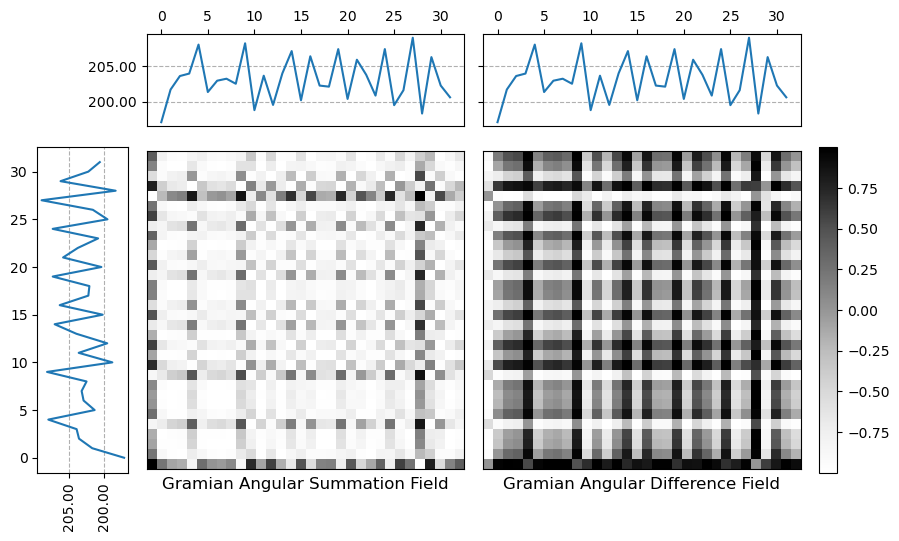

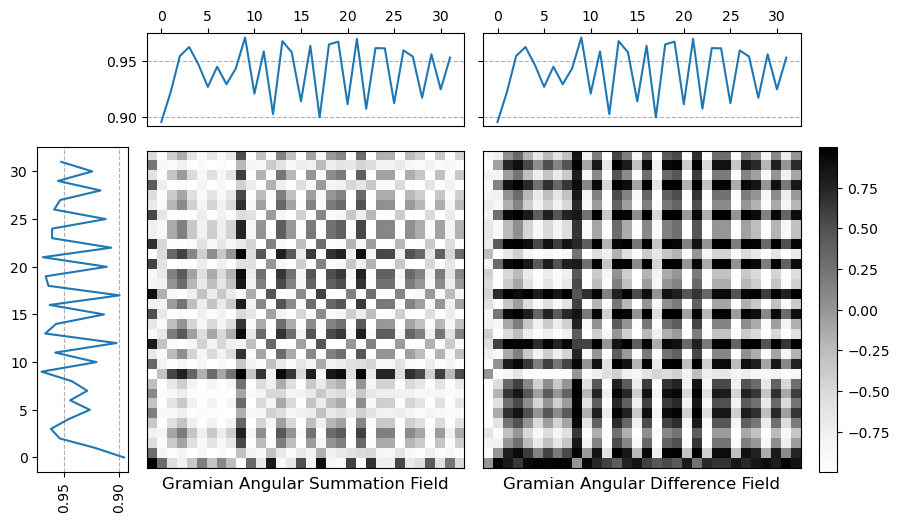

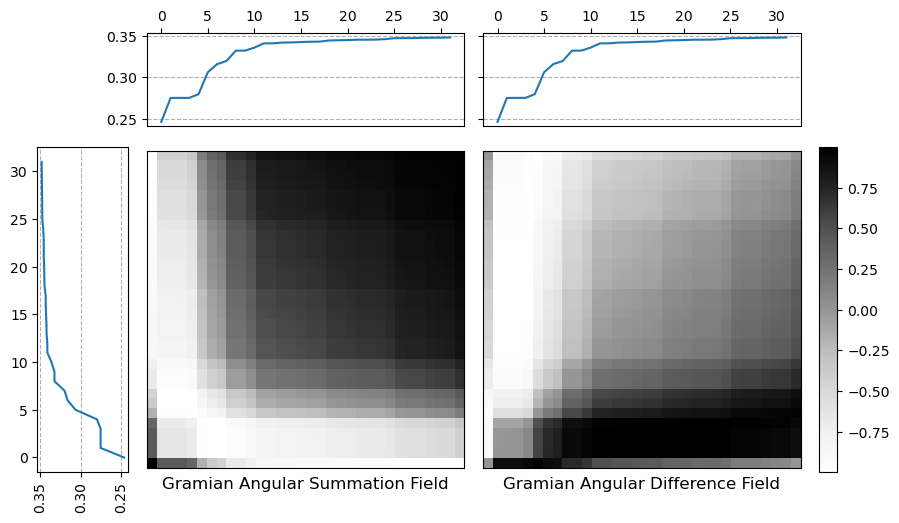

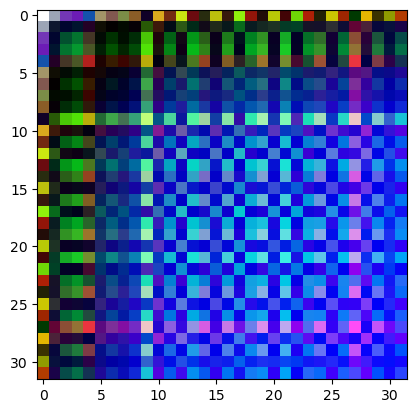

In [ ]:
w,h = figaspect(1/1)
fig, ax = plt.subplots(figsize=(w,h))

plt.imshow(img)
plt.savefig(f'./png/{jobid}_gramian_all.png', format='png', dpi=1000, bbox_inches = "tight")
plt.show()